In [1]:
rm(list=ls())
source("utilities.R")

##------------------------------------------------------------------------------##
## Load required packages and source all programs to be used in HLW estimation.
##------------------------------------------------------------------------------##
if (!require("tis")) {install.packages("tis"); library("tis")} ## Time series package
if (!require("mFilter")) {install.packages("mFilter"); library("mFilter")} # HP filter # nolint
if (!require("nloptr")) {install.packages("nloptr"); library("nloptr")} ## Optimization

Loading required package: tis

Loading required package: mFilter

Loading required package: nloptr



# 1. Input Data

In [2]:
# Set the start and end dates of the estimation sample as well as the data start date (format is c(year,quarter))
data.start   <- c(1960,1) # Input data starts
data.end <- c(2022,4)

sample.start <- c(1997,1) 
sample.end   <- data.end

## The estimation process uses data beginning 8 quarters prior to the sample start
est.data.start    <- shiftQuarter(sample.start,-8) # 1995

In [3]:
data.in <- read.table('/Users/yeonsoo/My Drive/Project/rstar/code/data/kor_input_with_imp.csv',
                    sep = ',', na.strings = ".",  header=TRUE, stringsAsFactors=FALSE)

In [4]:
# Set the inflation and interest rate data
inf <- 'EX' # ALL, CORE, EX
int <- 'CALL' # CALL, CD, TA, LB, X1Y

In [5]:
gdp.log <- tis(data.in['log.GDP'], start=data.start, end=data.end, tif='quarterly')
inflation <- tis(data.in[inf], start=data.start, end=data.end, tif='quarterly')
# inflation.expectations <- (inflation + Lag(inflation, k=1) + Lag(inflation, k=2) + Lag(inflation, k=3))/4 # MA(4)
import.price.inflation <- tis(data.in['IMP'], start=data.start, end=data.end, tif='quarterly')
relative.import.price.inflation <- import.price.inflation - inflation
# relative.oil.price.inflation <- tis(data.in['OIL'], start=data.start, end=data.end, tif='quarterly')
nominal.interest.rate <- tis(data.in[int], start=data.start, end=data.end, tif='quarterly')
# real.interest.rate <- nominal.interest.rate - inflation.expectations
real.interest.rate <- nominal.interest.rate - inflation

In [6]:
data.out <- window(cbind(gdp.log, inflation, relative.import.price.inflation, real.interest.rate),start = est.data.start, end = data.end) # relative.oil.price.inflation, inflation.expectations, 
colnames(data.out) <- c('gdp.log', 'inflation',  'relative.import.price.inflation',  'real.interest.rate ') # 'relative.oil.price.inflation', 'inflation.expectations',

In [7]:
kor.data <- as.data.frame(data.out)

log.output             <- kor.data$gdp.log 
inflation              <- kor.data$inflation # annualized inflation rate 
# inflation.expectations <- kor.data$inflation.expectations # 4-quarters MA (t, t-1, t-2, t-3) 
# relative.oil.price.inflation <- kor.data$relative.oil.price.inflation
relative.import.price.inflation <- kor.data$relative.import.price.inflation
real.interest.rate     <- kor.data$real.interest.rate

# 2. Model
* Relaxed New Keynesian framework 
    * (1) IS Curve
    $$ \tilde{y}_t = a_{1} \tilde{y}_{t-1} +  a_{2} \tilde{y}_{t-2} +\frac{a_3}{2} \Sigma^{2}_{j=1} (r_{t-j}-r^*_{t-j}) + \epsilon_{\tilde{y}, t}$$

    * (2) Philips Curve
    $$ \pi_t = b_{1} \pi_{t-1} + b_{2}\pi_{t-2, 4} + (1-b_{1}-b_{2})\pi_{t-5, 8} + b_{3} \tilde{y}_{t-1} + b_{4}(imp_{t}-\pi_{t}) + \epsilon_{\pi, t} $$

* Neoclassical growth model
    * (3) Potential GDP
    $$ y_t^* = y_{t-1}^* + g_{t} + \epsilon_{y^*, t}  $$
    * (4) Growth rate
    $$  g_t = g_{t-1} + \epsilon_{g,t} $$
    * (5) Real neutral rate
    $$ r_t^* = cg_t + z_t $$
    * (6) Shock
    $$ z_t = \rho z_{t-1} + \epsilon_{z,t} $$ 

In [8]:
### Constraints
# Upper bound on a_3 parameter (slope of the IS curve)
a.r.constraint.stage2 <- -0.0025
a.r.constraint.stage3 <- -0.0025 

# Lower bound on b_2 parameter (slope of the Phillips curve)
b.y.constraint.stage1 <- NA
b.y.constraint.stage2 <- 0.025
b.y.constraint.stage3 <- 0.025

In [9]:
## Set start index for y for initialization of state vector
g.pot.start.index <- 1 + ti(shiftQuarter(sample.start,-3),'quarterly')-ti(est.data.start,'quarterly')

## Set column names for CSV output
output.col.names <- c("Date","rstar (filtered)","g (filtered)","z (filtered)","output gap (filtered)","","All results are output from the Stage 3 model.",rep("",12),"Standard Errors","Date","y*","r*","g","","rrgap","","Date","rstar (smoothed)","g (smoothed)","z (smoothed)","output gap (smoothed)")

## Set number of iterations for Monte Carlo standard error procedure
niter <- 5000

## Because the MC standard error procedure is time consuming, we include a run switch
## Set run.se to TRUE to run the procedure
run.se <- TRUE

# 3. Estimation

In [10]:
source("calculate.covariance.R")
source("kalman.log.likelihood.R")
source("log.likelihood.wrapper.R")
source("kalman.standard.errors.R")
source("kalman.states.R")
source("kalman.states.wrapper.R")

## 3.1. Stage 1
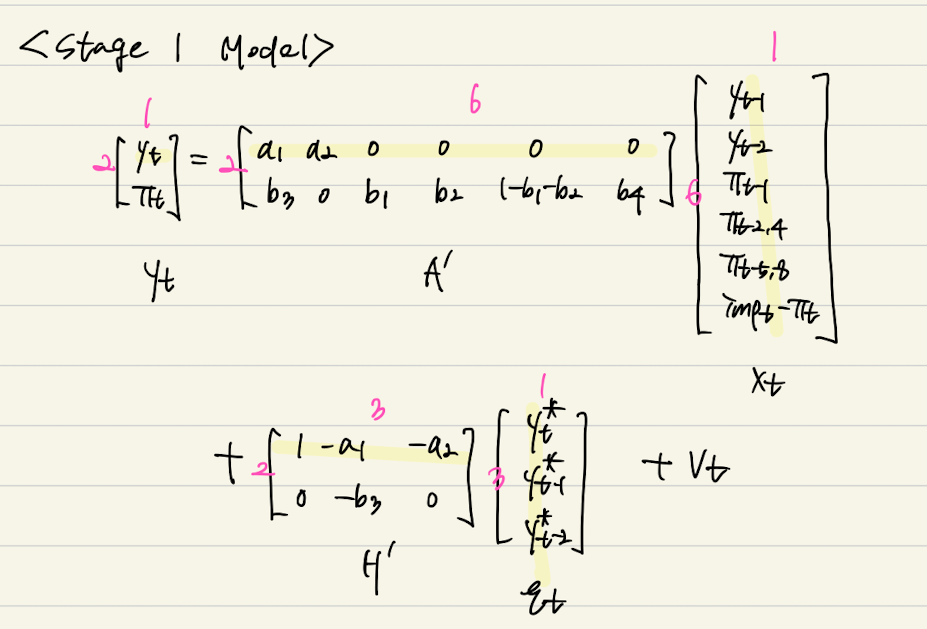
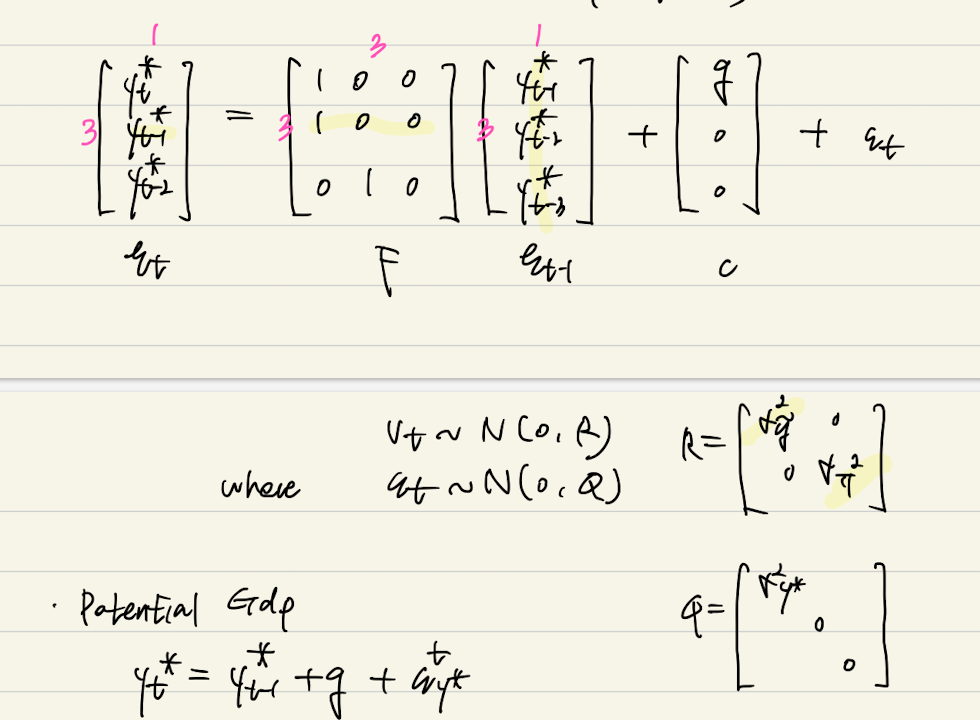

In [11]:
source("median.unbiased.estimator.stage1.R")
# source("unpack.parameters.stage1.R")

In [12]:
# parameters <- c(a1, a2, b1, b2, b3, b4, g, sigma_is, sigma_phillips, sigma_y*)

unpack.parameters.stage1 <- function(parameters, y.data, x.data, xi.00=NA, P.00=NA) {
  n.state.vars <- 3
    
  A         <- matrix(0, 6, 2)
  A[1:2, 1] <- parameters[1:2] # a1, a2
  A[1, 2]   <- parameters[5] # b3
  A[3:4, 2] <- parameters[3:4] # b1, b2
  A[5, 2]   <- 1-sum(A[3:4, 2]) # 1-b1-b2
  A[6, 2] <- parameters[6] # b4
  
  H         <- matrix(0, 3, 2)
  H[1, 1]   <- 1 
  H[2:3, 1] <- -parameters[1:2] # -a1, -a2
  H[2, 2]   <- -parameters[5] # -b3

  R         <- diag(c(parameters[8]^2, parameters[9]^2)) # sigma_is, sigma_phillips
  Q         <- matrix(0, 3, 3) 
  Q[1, 1]   <- parameters[10]^2  # sigma_y*

  F <- matrix(0, 3, 3)
  F[1, 1] <- F[2, 1] <- F[3, 2] <- 1

  cons <- matrix(0, 3, 1)
  cons[1, 1] <- parameters[7] # g = 0.85

  # Kalman filter initialization
  if (any(is.na(xi.00))) {
      xi.00 <- rep(0, n.state.vars) # y_t*, y_t-1*, y_t-2*
      
      ##  Starting values for xi.00 and P.00  
      x  <- rbind(t(H), t(H) %*% F, t(H) %*% F %*% F, t(H) %*% F %*% F %*% F) # 8*3
      om <- matrix(0, 8, 8) # 왜 8*8인지 이해하기
      om[5:6, 3:4] <- t(H) %*% F %*% Q %*% H 
      om[7:8, 3:4] <- t(H) %*% F %*% F %*% Q %*% H 
      om[7:8, 5:6] <- t(H) %*% (F %*% F %*% Q %*% t(F) + F %*% Q) %*% H  
      om           <- om + t(om)
      om[1:2, 1:2] <- R
      om[3:4, 3:4] <- t(H) %*% Q %*% H + R
      om[5:6, 5:6] <- t(H) %*% (F %*% Q %*% t(F) + Q) %*% H + R
      om[7:8, 7:8] <- t(H) %*% (F %*% F %*% Q %*% t(F) %*% t(F) + F %*% Q %*% t(F) + Q) %*% H + R
      
      p1 <- t(x) %*% solve(om, x) ## x' * inv(om) * x # 3*3
      yy <- c(y.data[1,], y.data[2,], y.data[3,], y.data[4,])
      tmp <- c(t(A) %*% x.data[1,],
              (t(A) %*% x.data[2,] + t(H) %*% cons),
              (t(A) %*% x.data[3,] + t(H) %*% cons + t(H) %*% F %*% cons),
              (t(A) %*% x.data[4,] + t(H) %*% (diag(n.state.vars)+F+F%*%F) %*% cons))
      xi.00 <- solve(p1, t(x)) %*% solve(om, yy - tmp) 
      tmp <- yy - tmp - x %*% xi.00
      P.00 <- solve(p1, (diag(nrow=3) * sum(tmp^2) / 3)) # 3*3
  }
  return(list("xi.00"=xi.00, "P.00"=P.00, "F"=F, "Q"=Q, "A"=A, "H"=H, "R"=R, "cons"=cons, "x.data"=x.data, "y.data"=y.data))
}

In [13]:
rstar.stage1 <- function(log.output,
                        inflation,
                        relative.import.price.inflation,
                        b.y.constraint=NA,
                        xi.00=NA, P.00=NA) {

  stage <- 1

  ## Data must start 8 quarters before estimation period
  T <- length(log.output) - 8

  ## Original output gap estimate
  x.og <- cbind(rep(1,T+4), 1:(T+4))
  # x.og <- cbind(rep(1,T+4), 1:(T+4), c(rep(0,56),1:(T+4-56)), c(rep(0,142),1:(T+4-142)))
  y.og <- log.output[5:(T+8)]
  output.gap <- (y.og - x.og %*% solve(t(x.og) %*% x.og, t(x.og) %*% y.og)) * 100
  
  ## IS curve
  y.is <- output.gap[5:(T+4)] # y_t
  x.is <- cbind(output.gap[4:(T+3)], output.gap[3:(T+2)]) # y_t-1, y_t-2
  b.is <- solve(t(x.is) %*% x.is, t(x.is) %*% y.is)
  r.is <- y.is - x.is %*% b.is
  s.is <- sqrt(sum(r.is^2) / (length(r.is)-2))

  ## Phillips curve
  y.ph <- inflation[9:(T+8)] # pi_t
  x.ph <- cbind(inflation[8:(T+7)], # pi_t-1
                (inflation[7:(T+6)]+inflation[6:(T+5)]+inflation[5:(T+4)])/3, # MA of pi_t-2, pi_t-3, pi_t-4
                (inflation[4:(T+3)]+inflation[3:(T+2)]+inflation[2:(T+1)]+inflation[1:T])/4, # MA of pi_t-5, pi_t-6, pi_t-7, pi_t-8
                output.gap[4:(T+3)], # y_t-1
                relative.import.price.inflation[9:(T+8)]) # imp_t - pi_t
  b.ph <- solve(t(x.ph) %*% x.ph, t(x.ph) %*% y.ph)
  r.ph <- y.ph - x.ph %*% b.ph
  s.ph <- sqrt(sum(r.ph^2) / (T-dim(x.ph)[2]))
  
  y.data <- cbind(100 * log.output[9:(T+8)], # y_t, pi_t
                  inflation[9:(T+8)])
  x.data <- cbind(100 * log.output[8:(T+7)], # y_t-1
                  100 * log.output[7:(T+6)], # y_t-2
                  inflation[8:(T+7)], # pi_t-1
                  (inflation[7:(T+6)]+inflation[6:(T+5)]+inflation[5:(T+4)])/3, # MA of pi_t-2, pi_t-3, pi_t-4
                  (inflation[4:(T+3)]+inflation[3:(T+2)]+inflation[2:(T+1)]+inflation[1:T])/4, # MA of pi_t-5, pi_t-6, pi_t-7, pi_t-8
                  relative.import.price.inflation[9:(T+8)]) # imp_t - pi_t

  ## Starting values for the parameter vector
  # initial.parameters <- c(b.is, b.ph[1:2], b.ph[4:6], 0.85, s.is, s.ph, 0.5)
  # a1, a2, b1, b2, b3(=1-b1-b2), b4, b5, g, sigma_is, sigma_phillips, sigma_y*
  initial.parameters <- c(b.is, b.ph[1:2], b.ph[4:5], 0.85, s.is, s.ph, 0.5) # g = 0.85, sigma_y* = 0.5

  ## Set an upper and lower bound on the parameter vectors:
  ## The vector is unbounded unless values are otherwise specified
  theta.lb <- c(rep(-Inf,length(initial.parameters)))
  theta.ub <- c(rep(Inf,length(initial.parameters)))
  
  ## Set a lower bound for the Phillips curve slope (b_y) of b.y.constraint, if not NA
  if (!is.na(b.y.constraint)) {
      print(paste("Setting a lower bound of b_y >",as.character(b.y.constraint),"in Stage 1"))
      if (initial.parameters[5] < b.y.constraint) {
          initial.parameters[5] <- b.y.constraint
      }
      theta.lb[5] <- b.y.constraint
  }
  
  ## Get parameter estimates via maximum likelihood
  f <- function(theta) {return(-log.likelihood.wrapper(theta, y.data, x.data, stage, NA, NA, xi.00, P.00)$ll.cum)}
  nloptr.out <- nloptr(initial.parameters, f, eval_grad_f=function(x) {gradient(f, x)},
                      lb=theta.lb, ub=theta.ub, opts=list("algorithm"="NLOPT_LD_LBFGS","xtol_rel"=1.0e-8,"maxeval"=200))
  theta <- nloptr.out$solution
  
  if (nloptr.out$status==-1 | nloptr.out$status==5) {
      print("Look at the termination conditions for nloptr in Stage 1")
      stop(nloptr.out$message)
  }
  
  log.likelihood <- log.likelihood.wrapper(theta, y.data, x.data, stage, NA, NA, xi.00, P.00)$ll.cum

  ## Get state vectors (xi.tt, xi.ttm1, xi.tT, P.tt, P.ttm1, P.tT) via Kalman filter
  states <- kalman.states.wrapper(theta, y.data, x.data, stage, NA, NA, xi.00, P.00)

  ## One-sided (filtered) estimates  
  potential.filtered  <- states$filtered$xi.tt[,1]/100
  output.gap.filtered <- y.data[,1] - (potential.filtered * 100)
  
#   ## Two-sided (smoothed) estimates
#   potential.smoothed  <- as.vector(states$smoothed$xi.tT[,1])/100
#   output.gap.smoothed <- y.data[,1] - (potential.smoothed * 100)  

  ## Save variables to return
  return.list                <- list()
  return.list$theta          <- theta
  return.list$log.likelihood <- log.likelihood
  return.list$states         <- states
  return.list$xi.00          <- xi.00
  return.list$P.00           <- P.00
  return.list$potential.filtered  <- potential.filtered
  return.list$output.gap.filtered <- output.gap.filtered
#   return.list$potential.smoothed  <- potential.smoothed
#   return.list$output.gap.smoothed <- output.gap.smoothed
  return(return.list)
}

In [14]:
### Compute kalman filtered data series only
kalman.states <- function(xi.tm1tm1, P.tm1tm1, F, Q, A, H, R, cons, y, x) {
  filtered <- kalman.states.filtered(xi.tm1tm1, P.tm1tm1, F, Q, A, H, R, cons, y, x)
#   smoothed <- kalman.states.smoothed(filtered$xi.ttm1, filtered$P.ttm1, filtered$xi.tt, filtered$P.tt,
#                                      F, Q, A, H, R, y, x)
#   return(list("filtered"=filtered, "smoothed"=smoothed))

  return(list("filtered"=filtered))
}

kalman.states.filtered <- function(xi.tm1tm1, P.tm1tm1, F, Q, A, H, R, cons, y, x, t=1) {
  xi.ttm1 <- as.vector(F %*% xi.tm1tm1 + cons)
  P.ttm1 <- F %*% P.tm1tm1 %*% t(F) + Q
  prediction.error <- (as.vector(y[t,]) - as.vector(t(A) %*% as.vector(x[t,])) - as.vector(t(H) %*% xi.ttm1))
  HPHR <- t(H) %*% P.ttm1 %*% H + R
  xi.tt <- xi.ttm1 + as.vector(P.ttm1 %*% H %*% solve(HPHR, prediction.error))
  P.tt <- P.ttm1 - P.ttm1 %*% H %*% solve(HPHR, t(H) %*% P.ttm1)
  if (t == dim(y)[1]) {
      return(list("xi.ttm1"=xi.ttm1, "P.ttm1"=P.ttm1, "xi.tt"=xi.tt, "P.tt"=P.tt))
  } else {
      tmp <- kalman.states.filtered(xi.tt, P.tt, F, Q, A, H, R, cons, y, x, t+1)
      return(list("xi.ttm1"=rbind(xi.ttm1, tmp$xi.ttm1),
                  "P.ttm1"=rbind(P.ttm1, tmp$P.ttm1),
                  "xi.tt"=rbind(xi.tt, tmp$xi.tt),
                  "P.tt"=rbind(P.tt, tmp$P.tt)))
  }
}

In [15]:
# kalman.states.smoothed <- function(xi.ttm1.array, P.ttm1.array, xi.tt.array, P.tt.array,
#                                 F, Q, A, H, R, y, x, t=dim(y)[1], xi.tp1T=NA, P.tp1T=NA) {
#     n <- dim(xi.ttm1.array)[2]
#     if (t == dim(y)[1]) {
#     xi.tT <- xi.tt.array[t,]
#     P.tT <- P.tt.array[((t-1)*n+1):(t*n),]
#     tmp <- kalman.states.smoothed(xi.ttm1.array, P.ttm1.array, xi.tt.array, P.tt.array,
#                                 F, Q, A, H, R, y, x, t-1, xi.tT, P.tT)
#     return(list("xi.tT"=rbind(tmp$xi.tT, xi.tT),
#                 "P.tT" =rbind(tmp$P.tT, P.tT)))
#     } else {
#     P.tt <- P.tt.array[((t-1)*n+1):(t*n),]
#     P.tp1t <- P.ttm1.array[(t*n+1):((t+1)*n),]
#     J.t <- P.tt %*% t(F) %*% solve(P.tp1t + 1e-10 * diag(n))
#     xi.tt <- xi.tt.array[t,]
#     xi.tp1t <- xi.ttm1.array[t+1,]
#     xi.tT <- xi.tt + as.vector(J.t %*% (xi.tp1T - xi.tp1t))
#     P.tT <- P.tt + J.t %*% (P.tp1T - P.tp1t) %*% t(J.t)
#     if (t > 1) {
#         tmp <- kalman.states.smoothed(xi.ttm1.array, P.ttm1.array, xi.tt.array, P.tt.array,
#                                     F, Q, A, H, R, y, x, t-1, xi.tT, P.tT)
#         return(list("xi.tT"=rbind(tmp$xi.tT, xi.tT),
#                     "P.tT" =rbind(tmp$P.tT, P.tT)))
#     } else {
#         return(list("xi.tT"=xi.tT, "P.tT"=P.tT))
#     }
#     }
# }

In [16]:
## Running the stage 1 model
out.stage1 <- rstar.stage1(log.output,
                        inflation,
                        relative.import.price.inflation,
                        b.y.constraint=b.y.constraint.stage1)

In [17]:
## Median unbiased estimate of lambda_g
# lambda.g <- median.unbiased.estimator.stage1(out.stage1$potential.smoothed)
lambda.g <- median.unbiased.estimator.stage1(out.stage1$potential.filtered)

In [18]:
lambda.g

[1] 0.1634472

## 3.2. Stage 2
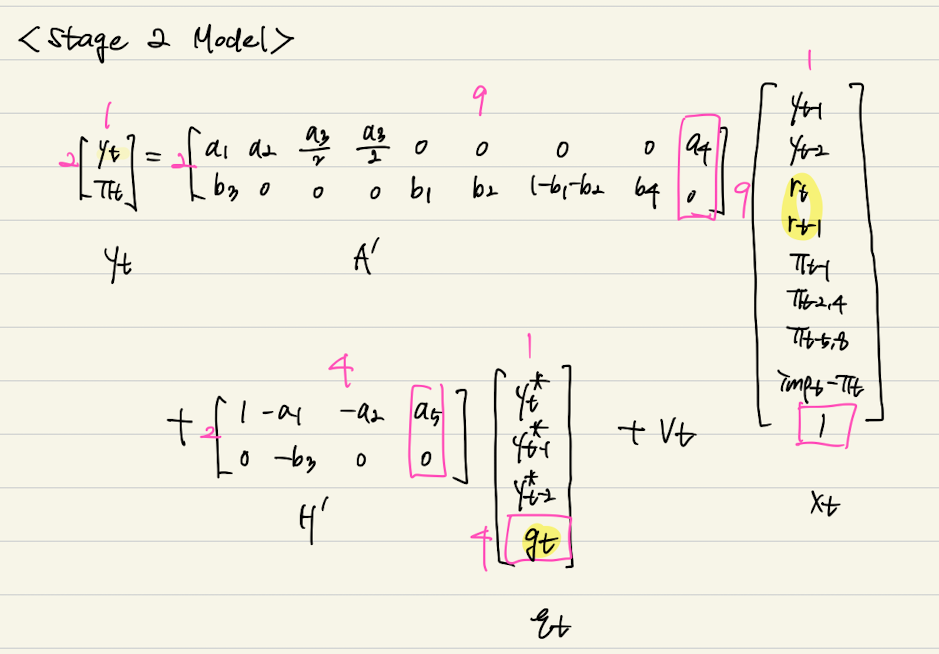
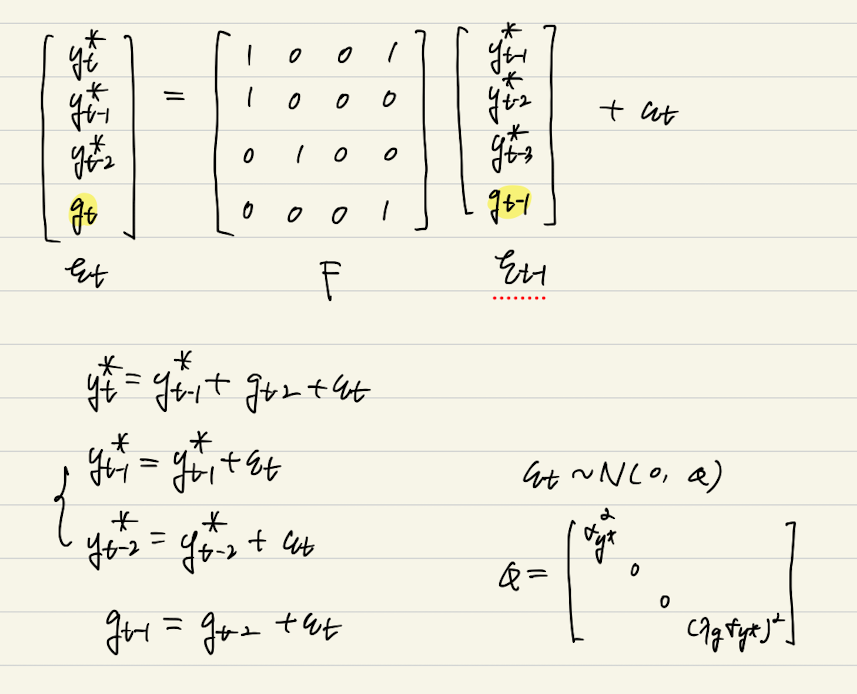

In [19]:
source("median.unbiased.estimator.stage2.R")
# source("unpack.parameters.stage2.R")

In [20]:
# parameters <- c(a1, a2, a3, a4, a5, b1, b2, b3, b4, sigma_is, sigma_phillips, sigma_y*)


unpack.parameters.stage2 <- function(parameters, y.data, x.data, lambda.g, xi.00=NA, P.00=NA) {
    n.state.vars <- 4
        
    A         <- matrix(0, 2, 9)
    A[1, 1:2] <- parameters[1:2] ## a_1, a_2
    A[1, 3:4] <- parameters[3]/2 ## a_3
    A[1, 9 ] <- parameters[4]   ## a_4
    A[2, 1  ] <- parameters[8]   ## b_3
    A[2, 5:6] <- parameters[6:7] ## b_1, b_2
    A[2, 7  ] <- 1 - parameters[6] - parameters[7] ## 1- b_1 - b_2
    A[2, 8  ] <- parameters[9] ##b_4
    A         <- t(A) # 2*9
    
    H         <- matrix(0, 2, 4)
    H[1, 1  ] <- 1
    H[1, 2:3] <- -parameters[1:2] ## a_1,a_2
    H[1, 4  ] <- parameters[5]    ## a_5
    H[2, 2]   <- -parameters[8]   ## b_3
    H         <- t(H)

    R         <- diag(c(parameters[10]^2, parameters[11]^2)) ## sigma_1,sigma_2
    Q         <- matrix(0, 4, 4)
    Q[1, 1]   <- parameters[12]^2              ## sigma_4
    Q[4, 4]   <- (lambda.g * parameters[12])^2 ## sigma_4

    F <- matrix(0, 4, 4)
    F[1, 1] <- F[1, 4] <- F[2, 1] <- F[3, 2] <- F[4,4] <- 1

    cons <- matrix(0, n.state.vars, 1)   # y_t*, y_t-1*, y_t-2*, gt
    
    # Kalman filter initialization
    ## Starting values for xi.00 and P.00
    if (any(is.na(xi.00))) {
        x  <- rbind(t(H), t(H) %*% F, t(H) %*% F %*% F, t(H) %*% F %*% F %*% F, t(H) %*% F %*% F %*% F %*% F)
        om <- matrix(0, 10, 10)
        om[5:6, 3:4] <- t(H) %*% F %*% Q %*% H
        om[7:8, 3:4] <- t(H) %*% F %*% F %*% Q %*% H
        om[9:10,3:4] <- t(H) %*% F %*% F %*% F %*% Q %*% H
        om[7:8, 5:6] <- t(H) %*% (F %*% F %*% Q %*% t(F) + F %*% Q) %*% H
        om[9:10,5:6] <- t(H) %*% F %*% (F %*% F %*% Q %*% t(F) + F %*% Q) %*% H
        om[9:10,7:8] <- t(H) %*% F %*% (F %*% F %*% Q %*% t(F) %*% t(F) + F %*% Q %*% t(F) + Q) %*% H
        om           <- om + t(om)
        om[1:2, 1:2] <- R
        om[3:4, 3:4] <- t(H) %*% Q %*% H + R
        om[5:6, 5:6] <- t(H) %*% (F %*% Q %*% t(F) + Q) %*% H + R
        om[7:8, 7:8] <- t(H) %*% (F %*% F %*% Q %*% t(F) %*% t(F) + F %*% Q %*% t(F) + Q) %*% H + R
        om[9:10, 9:10] <- t(H) %*% (F %*% F %*% F %*% Q %*% t(F) %*% t(F) %*% t(F) + F %*% F %*% Q %*% t(F) %*% t(F)
                                    + F %*% Q %*% t(F) + Q) %*% H + R
        p1 <- t(x) %*% solve(om, x)
        yy <- c(y.data[1,], y.data[2,], y.data[3,], y.data[4,], y.data[5,])
        tmp <- c(t(A) %*% x.data[1,],
                t(A) %*% x.data[2,],
                t(A) %*% x.data[3,],
                t(A) %*% x.data[4,],
                t(A) %*% x.data[5,])
        xi.00 <- solve(p1, t(x)) %*% solve(om, yy - tmp)
        tmp <- yy - tmp - x %*% xi.00
        P.00 <- solve(p1, (diag(nrow=4) * sum(tmp^2) / (length(yy) - n.state.vars)))
    }
    return(list("xi.00"=xi.00, "P.00"=P.00, "F"=F, "Q"=Q, "A"=A, "H"=H, "R"=R, "cons"=cons, "x.data"=x.data, "y.data"=y.data))
}


In [21]:
xi.00 <- NA
P.00 <- NA

In [22]:
  stage <- 2
  
  ## Data must start 8 quarters before estimation period
  T <- length(log.output) - 8

  ## Original output gap estimate
  x.og <- cbind(rep(1,T+4), 1:(T+4)) 
  # x.og <- cbind(rep(1,T+4), 1:(T+4), c(rep(0,56),1:(T+4-56)), c(rep(0,142),1:(T+4-142)))
  y.og <- log.output[5:(T+8)]
  output.gap <- (y.og - x.og %*% solve(t(x.og) %*% x.og, t(x.og) %*% y.og)) * 100 

  ## IS curve
  y.is <- output.gap[5:(T+4)] # y_t
  x.is <- cbind(output.gap[4:(T+3)], output.gap[3:(T+2)], # y_t-1, # y_t-2
                # (real.interest.rate[8:(T+7)] + real.interest.rate[7:(T+6)])/2, # r_t-1, # r_t-2
                (real.interest.rate[9:(T+8)] + real.interest.rate[8:(T+7)])/2, # r_t, # r_t-1
                rep(1,T))
  b.is <- solve(t(x.is) %*% x.is, t(x.is) %*% y.is)
  r.is <- y.is - x.is %*% b.is
  s.is <- sqrt(sum(r.is^2) / (T-dim(x.is)[2]))
  
  ## Phillips curve
  y.ph <- inflation[9:(T+8)] # pi_t
  x.ph <- cbind(inflation[8:(T+7)], # pi_t-1
                (inflation[7:(T+6)]+inflation[6:(T+5)]+inflation[5:(T+4)])/3, # MA of pi_t-2, pi_t-3, pi_t-4
                (inflation[4:(T+3)]+inflation[3:(T+2)]+inflation[2:(T+1)]+inflation[1:T])/4, # MA of pi_t-5, pi_t-6, pi_t-7, pi_t-8
                output.gap[4:(T+3)],  # y_t-1
                relative.import.price.inflation[9:(T+8)]) # imp_t - pi_t
  b.ph <- solve(t(x.ph) %*% x.ph, t(x.ph) %*% y.ph)
  r.ph <- y.ph - x.ph %*% b.ph
  s.ph <- sqrt(sum(r.ph^2) / (T-dim(x.ph)[2]))
  
  y.data <- cbind(100 * log.output[9:(T+8)],
                  inflation[9:(T+8)])
  x.data <- cbind(100 * log.output[8:(T+7)],
                  100 * log.output[7:(T+6)],         
                  real.interest.rate[9:(T+8)],
                  real.interest.rate[8:(T+7)],
                  inflation[8:(T+7)],
                  (inflation[7:(T+6)]+inflation[6:(T+5)]+inflation[5:(T+4)])/3,
                  (inflation[4:(T+3)]+inflation[3:(T+2)]+inflation[2:(T+1)]+inflation[1:T])/4,
                  relative.import.price.inflation[9:(T+8)],
                  rep(1,T))

  ## Starting values for the parameter vector
  # initial.parameters <- c(b.is, -b.is[3], b.ph[1:2], b.ph[4:6], s.is, s.ph, 0.5)
  # a1, a2, a3, a4, a5(=-a3), b1, b2, b4, b5, sigma_is, sigma_phillips, sigma_y*
  parameters <- c(b.is, -b.is[3], b.ph[1:2], b.ph[4:5], s.is, s.ph, 0.5)

In [23]:
rstar.stage2 <- function(log.output,
                         inflation,
                         relative.import.price.inflation,                         
                         real.interest.rate,
                         lambda.g,
                         a.r.constraint=NA,
                         b.y.constraint=NA,
                         xi.00=NA, P.00=NA) {

  stage <- 2
  
  ## Data must start 8 quarters before estimation period
  T <- length(log.output) - 8

  ## Original output gap estimate
  x.og <- cbind(rep(1,T+4), 1:(T+4)) 
  # x.og <- cbind(rep(1,T+4), 1:(T+4), c(rep(0,56),1:(T+4-56)), c(rep(0,142),1:(T+4-142)))
  y.og <- log.output[5:(T+8)]
  output.gap <- (y.og - x.og %*% solve(t(x.og) %*% x.og, t(x.og) %*% y.og)) * 100 

  ## IS curve
  y.is <- output.gap[5:(T+4)] # y_t
  x.is <- cbind(output.gap[4:(T+3)], output.gap[3:(T+2)], # y_t-1, # y_t-2
                # (real.interest.rate[8:(T+7)] + real.interest.rate[7:(T+6)])/2, # r_t-1, # r_t-2
                (real.interest.rate[9:(T+8)] + real.interest.rate[8:(T+7)])/2, # r_t, # r_t-1
                rep(1,T))
  b.is <- solve(t(x.is) %*% x.is, t(x.is) %*% y.is)
  r.is <- y.is - x.is %*% b.is
  s.is <- sqrt(sum(r.is^2) / (T-dim(x.is)[2]))
  
  ## Phillips curve
  y.ph <- inflation[9:(T+8)] # pi_t
  x.ph <- cbind(inflation[8:(T+7)], # pi_t-1
                (inflation[7:(T+6)]+inflation[6:(T+5)]+inflation[5:(T+4)])/3, # MA of pi_t-2, pi_t-3, pi_t-4
                (inflation[4:(T+3)]+inflation[3:(T+2)]+inflation[2:(T+1)]+inflation[1:T])/4, # MA of pi_t-5, pi_t-6, pi_t-7, pi_t-8
                output.gap[4:(T+3)],  # y_t-1
                relative.import.price.inflation[9:(T+8)]) # imp_t - pi_t
  b.ph <- solve(t(x.ph) %*% x.ph, t(x.ph) %*% y.ph)
  r.ph <- y.ph - x.ph %*% b.ph
  s.ph <- sqrt(sum(r.ph^2) / (T-dim(x.ph)[2]))
  
  y.data <- cbind(100 * log.output[9:(T+8)],
                  inflation[9:(T+8)])
  x.data <- cbind(100 * log.output[8:(T+7)],
                  100 * log.output[7:(T+6)],         
                  real.interest.rate[9:(T+8)],
                  real.interest.rate[8:(T+7)],
                  inflation[8:(T+7)],
                  (inflation[7:(T+6)]+inflation[6:(T+5)]+inflation[5:(T+4)])/3,
                  (inflation[4:(T+3)]+inflation[3:(T+2)]+inflation[2:(T+1)]+inflation[1:T])/4,
                  relative.import.price.inflation[9:(T+8)],
                  rep(1,T))

  ## Starting values for the parameter vector
  # initial.parameters <- c(b.is, -b.is[3], b.ph[1:2], b.ph[4:6], s.is, s.ph, 0.5)
  # a1, a2, a3, a4, a5(=-a3), b1, b2, b4, b5, sigma_is, sigma_phillips, sigma_y*
  initial.parameters <- c(b.is, -b.is[3], b.ph[1:2], b.ph[4:5], s.is, s.ph, 0.5)

  ## Set an upper and lower bound on the parameter vectors:
  ## The vector is unbounded unless values are otherwise specified
  theta.lb <- c(rep(-Inf,length(initial.parameters)))
  theta.ub <- c(rep(Inf,length(initial.parameters)))

  ## Set a lower bound for the Phillips curve slope (b_2) of b.y.constraint, if not NA
  if (!is.na(b.y.constraint)) {
      print(paste("Setting a lower bound of b_y >",as.character(b.y.constraint),"in Stage 2"))
      if (initial.parameters[8] < b.y.constraint) {
          initial.parameters[8] <- b.y.constraint
      }
      theta.lb[8] <- b.y.constraint
  }

  ## Set an upper bound for the IS curve slope (a_3) of a.r.constraint, if not NA
  if (!is.na(a.r.constraint)) {
      print(paste("Setting an upper bound of a_r <",as.character(a.r.constraint),"in Stage 2"))
      if (initial.parameters[3] > a.r.constraint) {
          initial.parameters[3] <- a.r.constraint
      }
      theta.ub[3] <- a.r.constraint      
  }

  ## Get parameter estimates via maximum likelihood
  f <- function(theta) {return(-log.likelihood.wrapper(theta, y.data, x.data, stage, lambda.g, NA, xi.00, P.00)$ll.cum)}
  nloptr.out <- nloptr(initial.parameters, f, eval_grad_f=function(x) {gradient(f, x)},
                       lb=theta.lb,ub=theta.ub,
                       opts=list("algorithm"="NLOPT_LD_LBFGS","xtol_rel"=1.0e-8,"maxeval"=200))
  theta <- nloptr.out$solution

  if (nloptr.out$status==-1 | nloptr.out$status==5) {
      print("Look at the termination conditions for nloptr in Stage 2")
      stop(nloptr.out$message)
  }

  log.likelihood <- log.likelihood.wrapper(theta, y.data, x.data, stage, lambda.g, NA, xi.00, P.00)$ll.cum

  ## Get state vectors (xi.tt, xi.ttm1, xi.tT, P.tt, P.ttm1, P.tT) via Kalman filter
  states <- kalman.states.wrapper(theta, y.data, x.data, stage, lambda.g, NA, xi.00, P.00)

  ## Two-sided (smoothed) estimates
  # trend.smoothed      <- states$smoothed$xi.tt[,4] * 4
  # potential.smoothed  <- c(states$smoothed$xi.tT[1, 3:2], states$smoothed$xi.tT[,1])
  # output.gap.smoothed <- 100 * log.output[7:(T+8)] - potential.smoothed

  # ## Inputs for median.unbiased.estimator.stage2.R
  # y <- output.gap.smoothed[3:length(output.gap.smoothed)]
  # x <- cbind(output.gap.smoothed[2:(length(output.gap.smoothed)-1)],
  #            output.gap.smoothed[1:(length(output.gap.smoothed)-2)],
  #            (x.data[,3]+x.data[,4])/2,
  #            states$smoothed$xi.tT[,4],
  #            rep(1,T))
  

  ## One-sided (filtered) estimates  
  trend.filtered      <- states$filtered$xi.tt[,4] * 4
  potential.filtered  <- states$filtered$xi.tt[,1]/100
  output.gap.filtered <- y.data[,1] - (potential.filtered * 100)

  # ## Inputs for median.unbiased.estimator.stage2.R
  # y <- output.gap.filtered[3:length(output.gap.filtered)]
  # x <- cbind(output.gap.filtered[2:(length(output.gap.filtered)-1)],
  #            output.gap.filtered[1:(length(output.gap.filtered)-2)],
  #            (x.data[,3]+x.data[,4])/2,
  #            states$filtered$xi.tT[,4],
  #            rep(1,T))

  ## Save variables to return
  return.list <- list()
#   return.list$y              <- y
#   return.list$x              <- x
  return.list$theta          <- theta
  return.list$log.likelihood <- log.likelihood
  return.list$states         <- states
  return.list$xi.00          <- xi.00
  return.list$P.00           <- P.00
  return.list$trend.filtered      <- trend.filtered
  return.list$potential.filtered  <- potential.filtered
  return.list$output.gap.filtered <- output.gap.filtered
#   return.list$trend.smoothed      <- trend.smoothed
#   return.list$potential.smoothed  <- potential.smoothed
#   return.list$output.gap.smoothed <- output.gap.smoothed
  return(return.list)
}

In [33]:
                           a.r.constraint<-a.r.constraint.stage2
                           b.y.constraint<-b.y.constraint.stage2
  stage <- 2
  
  ## Data must start 8 quarters before estimation period
  T <- length(log.output) - 8

  ## Original output gap estimate
  x.og <- cbind(rep(1,T+4), 1:(T+4)) 
  # x.og <- cbind(rep(1,T+4), 1:(T+4), c(rep(0,56),1:(T+4-56)), c(rep(0,142),1:(T+4-142)))
  y.og <- log.output[5:(T+8)]
  output.gap <- (y.og - x.og %*% solve(t(x.og) %*% x.og, t(x.og) %*% y.og)) * 100 

  ## IS curve
  y.is <- output.gap[5:(T+4)] # y_t
  x.is <- cbind(output.gap[4:(T+3)], output.gap[3:(T+2)], # y_t-1, # y_t-2
                # (real.interest.rate[8:(T+7)] + real.interest.rate[7:(T+6)])/2, # r_t-1, # r_t-2
                (real.interest.rate[9:(T+8)] + real.interest.rate[8:(T+7)])/2, # r_t, # r_t-1
                rep(1,T))
  b.is <- solve(t(x.is) %*% x.is, t(x.is) %*% y.is)
  r.is <- y.is - x.is %*% b.is
  s.is <- sqrt(sum(r.is^2) / (T-dim(x.is)[2]))
  
  ## Phillips curve
  y.ph <- inflation[9:(T+8)] # pi_t
  x.ph <- cbind(inflation[8:(T+7)], # pi_t-1
                (inflation[7:(T+6)]+inflation[6:(T+5)]+inflation[5:(T+4)])/3, # MA of pi_t-2, pi_t-3, pi_t-4
                (inflation[4:(T+3)]+inflation[3:(T+2)]+inflation[2:(T+1)]+inflation[1:T])/4, # MA of pi_t-5, pi_t-6, pi_t-7, pi_t-8
                output.gap[4:(T+3)],  # y_t-1
                relative.import.price.inflation[9:(T+8)]) # imp_t - pi_t
  b.ph <- solve(t(x.ph) %*% x.ph, t(x.ph) %*% y.ph)
  r.ph <- y.ph - x.ph %*% b.ph
  s.ph <- sqrt(sum(r.ph^2) / (T-dim(x.ph)[2]))
  
  y.data <- cbind(100 * log.output[9:(T+8)],
                  inflation[9:(T+8)])
  x.data <- cbind(100 * log.output[8:(T+7)],
                  100 * log.output[7:(T+6)],         
                  real.interest.rate[9:(T+8)],
                  real.interest.rate[8:(T+7)],
                  inflation[8:(T+7)],
                  (inflation[7:(T+6)]+inflation[6:(T+5)]+inflation[5:(T+4)])/3,
                  (inflation[4:(T+3)]+inflation[3:(T+2)]+inflation[2:(T+1)]+inflation[1:T])/4,
                  relative.import.price.inflation[9:(T+8)],
                  rep(1,T))

  ## Starting values for the parameter vector
  # initial.parameters <- c(b.is, -b.is[3], b.ph[1:2], b.ph[4:6], s.is, s.ph, 0.5)
  # a1, a2, a3, a4, a5(=-a3), b1, b2, b4, b5, sigma_is, sigma_phillips, sigma_y*
  initial.parameters <- c(b.is, -b.is[3], b.ph[1:2], b.ph[4:5], s.is, s.ph, 0.5)

  ## Set an upper and lower bound on the parameter vectors:
  ## The vector is unbounded unless values are otherwise specified
  theta.lb <- c(rep(-Inf,length(initial.parameters)))
  theta.ub <- c(rep(Inf,length(initial.parameters)))

  ## Set a lower bound for the Phillips curve slope (b_2) of b.y.constraint, if not NA
  if (!is.na(b.y.constraint)) {
      print(paste("Setting a lower bound of b_y >",as.character(b.y.constraint),"in Stage 2"))
      if (initial.parameters[8] < b.y.constraint) {
          initial.parameters[8] <- b.y.constraint
      }
      theta.lb[8] <- b.y.constraint
  }

  ## Set an upper bound for the IS curve slope (a_3) of a.r.constraint, if not NA
  if (!is.na(a.r.constraint)) {
      print(paste("Setting an upper bound of a_r <",as.character(a.r.constraint),"in Stage 2"))
      if (initial.parameters[3] > a.r.constraint) {
          initial.parameters[3] <- a.r.constraint
      }
      theta.ub[3] <- a.r.constraint      
  }

  ## Get parameter estimates via maximum likelihood
  f <- function(theta) {return(-log.likelihood.wrapper(theta, y.data, x.data, stage, lambda.g, NA, xi.00, P.00)$ll.cum)}
  nloptr.out <- nloptr(initial.parameters, f, eval_grad_f=function(x) {gradient(f, x)},
                       lb=theta.lb,ub=theta.ub,
                       opts=list("algorithm"="NLOPT_LD_LBFGS","xtol_rel"=1.0e-8,"maxeval"=200))
  theta <- nloptr.out$solution

  if (nloptr.out$status==-1 | nloptr.out$status==5) {
      print("Look at the termination conditions for nloptr in Stage 2")
      stop(nloptr.out$message)
  }

  log.likelihood <- log.likelihood.wrapper(theta, y.data, x.data, stage, lambda.g, NA, xi.00, P.00)$ll.cum

  ## Get state vectors (xi.tt, xi.ttm1, xi.tT, P.tt, P.ttm1, P.tT) via Kalman filter
  states <- kalman.states.wrapper(theta, y.data, x.data, stage, lambda.g, NA, xi.00, P.00)

[1] "Setting a lower bound of b_y > 0.025 in Stage 2"
[1] "Setting an upper bound of a_r < -0.0025 in Stage 2"


In [35]:
  ## One-sided (filtered) estimates  
  trend.filtered      <- states$filtered$xi.tt[,4] * 4
  potential.filtered  <- states$filtered$xi.tt[,1]/100
  output.gap.filtered <- y.data[,1] - (potential.filtered * 100)

In [36]:
  ## Inputs for median.unbiased.estimator.stage2.R
  y <- output.gap.filtered[3:length(output.gap.filtered)]
  x <- cbind(output.gap.filtered[2:(length(output.gap.filtered)-1)],
             output.gap.filtered[1:(length(output.gap.filtered)-2)],
             (x.data[,3]+x.data[,4])/2,
             states$filtered$xi.tT[,4],
             rep(1,T))


Warning message in cbind(output.gap.filtered[2:(length(output.gap.filtered) - 1)], :
"number of rows of result is not a multiple of vector length (arg 1)"


In [24]:
## Running the stage 2 model
out.stage2 <- rstar.stage2(log.output,
                           inflation,
                           relative.import.price.inflation,
                           real.interest.rate,                         
                           lambda.g,
                           a.r.constraint=a.r.constraint.stage2,
                           b.y.constraint=b.y.constraint.stage2)

[1] "Setting a lower bound of b_y > 0.025 in Stage 2"
[1] "Setting an upper bound of a_r < -0.0025 in Stage 2"


In [1]:
## Median unbiased estimate of lambda_z
lambda.z <- median.unbiased.estimator.stage2(out.stage2$y, out.stage2$x)

In [ ]:
lambda.z

[1] 0.03636369

## 3.3. Stage 3

In [ ]:
source("rstar.stage3.R")
source("unpack.parameters.stage3.R")

In [ ]:
rstar.stage3 <- function(log.output,
                         inflation,
                         relative.oil.price.inflation,
                         relative.import.price.inflation,
                         real.interest.rate,
                         lambda.g,
                         lambda.z,
                         a.r.constraint=NA,
                         b.y.constraint=NA,
                         run.se=FALSE,
                         xi.00=NA, P.00=NA) {

  stage <- 3
  
  ## Data must start 8 quarters before estimation period
  T <- length(log.output) - 8
  
  ## Original output gap estimate
  x.og <- cbind(rep(1,T+4), 1:(T+4))
  # x.og <- cbind(rep(1,T+4), 1:(T+4), c(rep(0,56),1:(T+4-56)), c(rep(0,142),1:(T+4-142)))
  y.og <- log.output[5:(T+8)]
  output.gap <- (y.og - x.og %*% solve(t(x.og) %*% x.og, t(x.og) %*% y.og)) * 100

  
  ## Initialization of state vector for Kalman filter using HP trend of log output
  ## Pulled into unpack.parameters.stage3.R
  b.pot <- solve(t(x.og) %*% x.og, t(x.og) %*% y.og)
  g.pot <- x.og %*% solve(t(x.og) %*% x.og, t(x.og) %*% y.og)
  xi.00.gpot <- c(100*g.pot[5:3],100*b.pot[2],100*b.pot[2],0,0)
                                               
  ## IS curve
  y.is <- output.gap[5:(T+4)]
  x.is <- cbind(output.gap[4:(T+3)], output.gap[3:(T+2)],
                (real.interest.rate[8:(T+7)] + real.interest.rate[7:(T+6)])/2,
                rep(1,T))
  b.is <- solve(t(x.is) %*% x.is, t(x.is) %*% y.is)
  r.is <- y.is - x.is %*% b.is
  s.is <- sqrt(sum(r.is^2) / (T-dim(x.is)[2]))

  ## Phillips curve
  y.ph <- inflation[9:(T+8)]
  x.ph <- cbind(inflation[8:(T+7)],
                (inflation[7:(T+6)]+inflation[6:(T+5)]+inflation[5:(T+4)])/3,
                (inflation[4:(T+3)]+inflation[3:(T+2)]+inflation[2:(T+1)]+inflation[1:T])/4,
                output.gap[4:(T+3)],
                relative.oil.price.inflation[8:(T+7)],
                relative.import.price.inflation[9:(T+8)])
  b.ph <- solve(t(x.ph) %*% x.ph, t(x.ph) %*% y.ph)
  r.ph <- y.ph - x.ph %*% b.ph
  s.ph <- sqrt(sum(r.ph^2) / (T-dim(x.ph)[2]))
  
  y.data <- cbind(100 * log.output[9:(T+8)],
                  inflation[9:(T+8)])
  x.data <- cbind(100 * log.output[8:(T+7)],
                  100 * log.output[7:(T+6)],
                  real.interest.rate[8:(T+7)],
                  real.interest.rate[7:(T+6)],                  
                  inflation[8:(T+7)],
                  (inflation[7:(T+6)]+inflation[6:(T+5)]+inflation[5:(T+4)])/3,
                  (inflation[4:(T+3)]+inflation[3:(T+2)]+inflation[2:(T+1)]+inflation[1:T])/4,
                  relative.oil.price.inflation[8:(T+7)],
                  relative.import.price.inflation[9:(T+8)])
  
  initial.parameters <- c(b.is[1:3], b.ph[1:2], b.ph[4:6], 1, s.is, s.ph, 0.7)
  
  theta.lb <- c(rep(-Inf,length(initial.parameters)))
  theta.ub <- c(rep(Inf,length(initial.parameters)))

  ## Set a lower bound for the Phillips curve slope (b_2) of b.y.constraint, if not NA
  if (!is.na(b.y.constraint)) {
      print(paste("Setting a lower bound of b_y >",as.character(b.y.constraint),"in Stage 3"))
      if (initial.parameters[6] < b.y.constraint) {
          initial.parameters[6] <- b.y.constraint
      }
      theta.lb[6] <- b.y.constraint
  }

  ## Set an upper bound for the IS curve slope (a_3) of a.r.constraint, if not NA
  if (!is.na(a.r.constraint)) {
      print(paste("Setting an upper bound of a_r <",as.character(a.r.constraint),"in Stage 3"))
      if (initial.parameters[3] > a.r.constraint) {
          initial.parameters[3] <- a.r.constraint
      }
      theta.ub[3] <- a.r.constraint      
  }

  P.00.gpot <- calculate.covariance(initial.parameters, theta.lb, theta.ub, y.data, x.data, stage, lambda.g, lambda.z, xi.00=xi.00.gpot)
    
  f <- function(theta) {return(-log.likelihood.wrapper(theta, y.data, x.data, stage,
                                                       lambda.g, lambda.z,
                                                       xi.00=NA, P.00=NA,
                                                       xi.00.gpot, P.00.gpot)$ll.cum)}
  nloptr.out <- nloptr(initial.parameters, f, eval_grad_f=function(x) {gradient(f, x)},
                       lb=theta.lb,ub=theta.ub,
                       opts=list("algorithm"="NLOPT_LD_LBFGS","xtol_rel"=1.0e-8,"maxeval"=200))
  theta <- nloptr.out$solution
  
  if (nloptr.out$status==-1 | nloptr.out$status==5) {
      print("Look at the termination conditions for nloptr in Stage 3")
      stop(nloptr.out$message)
  }

  ## Get xi.00 and P.00
  init.vals <- unpack.parameters.stage3(theta, y.data, x.data, lambda.g, lambda.z,
                                        xi.00=NA, P.00=NA, xi.00.gpot, P.00.gpot)
  xi.00 <- init.vals$xi.00
  P.00  <- init.vals$P.00
  print(paste("GLS switch value:",init.vals$gls))
  
  log.likelihood <- log.likelihood.wrapper(theta, y.data, x.data, stage, lambda.g, lambda.z, xi.00, P.00)$ll.cum
  states <- kalman.states.wrapper(theta, y.data, x.data, stage, lambda.g, lambda.z, xi.00, P.00)

  ## If run.se = TRUE, compute standard errors for estimates of the states and report run time
  if (run.se) {
      ptm <- proc.time()
      se <- kalman.standard.errors(T, states, theta, y.data, x.data, stage, lambda.g, lambda.z, xi.00, P.00, niter, a.r.constraint, b.y.constraint)
      print("Standard error procedure run time")
      print(proc.time() - ptm)
  }
  
  ## One-sided (filtered) estimates
  trend.filtered      <- states$filtered$xi.tt[,4] * 4
  z.filtered          <- states$filtered$xi.tt[,6]
  rstar.filtered      <- trend.filtered * theta[9] + z.filtered
  potential.filtered  <- states$filtered$xi.tt[,1]/100
  output.gap.filtered <- y.data[,1] - (potential.filtered * 100)

  ## Two-sided (smoothed) estimates
  trend.smoothed      <- states$smoothed$xi.tT[,4] * 4
  z.smoothed          <- states$smoothed$xi.tT[,6]
  rstar.smoothed      <- trend.smoothed * theta[9] + z.smoothed
  potential.smoothed  <- states$smoothed$xi.tT[,1]/100
  output.gap.smoothed <- y.data[,1] - (potential.smoothed * 100)
   
  ## Save variables to return
  return.list <- list()
  return.list$rstar.filtered      <- rstar.filtered
  return.list$trend.filtered      <- trend.filtered
  return.list$z.filtered          <- z.filtered
  return.list$potential.filtered  <- potential.filtered
  return.list$output.gap.filtered <- output.gap.filtered
  return.list$rstar.smoothed      <- rstar.smoothed
  return.list$trend.smoothed      <- trend.smoothed
  return.list$z.smoothed          <- z.smoothed
  return.list$potential.smoothed  <- potential.smoothed
  return.list$output.gap.smoothed <- output.gap.smoothed
  return.list$theta               <- theta
  return.list$log.likelihood      <- log.likelihood
  return.list$states              <- states
  return.list$xi.00               <- xi.00
  return.list$P.00                <- P.00
  return.list$y.data              <- y.data
  return.list$initial.parameters  <- initial.parameters
  return.list$init.vals           <- init.vals
  if (run.se) { return.list$se    <- se }
  return(return.list)
}

In [ ]:
out.stage3 <- rstar.stage3(log.output,
                           inflation,
                           relative.oil.price.inflation,
                           relative.import.price.inflation,
                           real.interest.rate,
                           lambda.g,
                           lambda.z,
                           a.r.constraint=a.r.constraint.stage3,
                           b.y.constraint=b.y.constraint.stage3,
                           run.se)

[1] "Setting a lower bound of b_y > 0.025 in Stage 3"
[1] "Setting an upper bound of a_r < -0.0025 in Stage 3"
[1] "GLS switch value: FALSE"
[1] "Computing Standard Errors"
[1] "Standard Error Procedure: a.r.constraint"
[1] -0.0025
[1] "Standard Error Procedure: b.y.constraint"
[1] 0.025
[1] "Standard error procedure run time"
   user  system elapsed 
146.687   9.393 161.151 


In [ ]:
## One-sided (filtered) estimates
one.sided.est <- cbind(out.stage3$rstar.filtered,
                       out.stage3$trend.filtered,
                       out.stage3$z.filtered,
                       out.stage3$output.gap.filtered)

## Two-sided (smoothed) estimates
two.sided.est <- cbind(out.stage3$rstar.smoothed,
                       out.stage3$trend.smoothed,
                       out.stage3$z.smoothed,
                       out.stage3$output.gap.smoothed)

In [ ]:
source("format.output.R")

In [ ]:
# Save output to CSV
library(stringr)
file.name <- paste('output/',data.start[1],'Q',data.start[2],'_',data.end[1],'Q',data.end[2],'_',inf,'_',int,'.csv')
file.name <- str_replace_all(file.name," ","")
write.table(output, file.name, col.names = output.col.names, quote=FALSE, row.names=FALSE, sep = ',', na = '')

# 4. Visualization

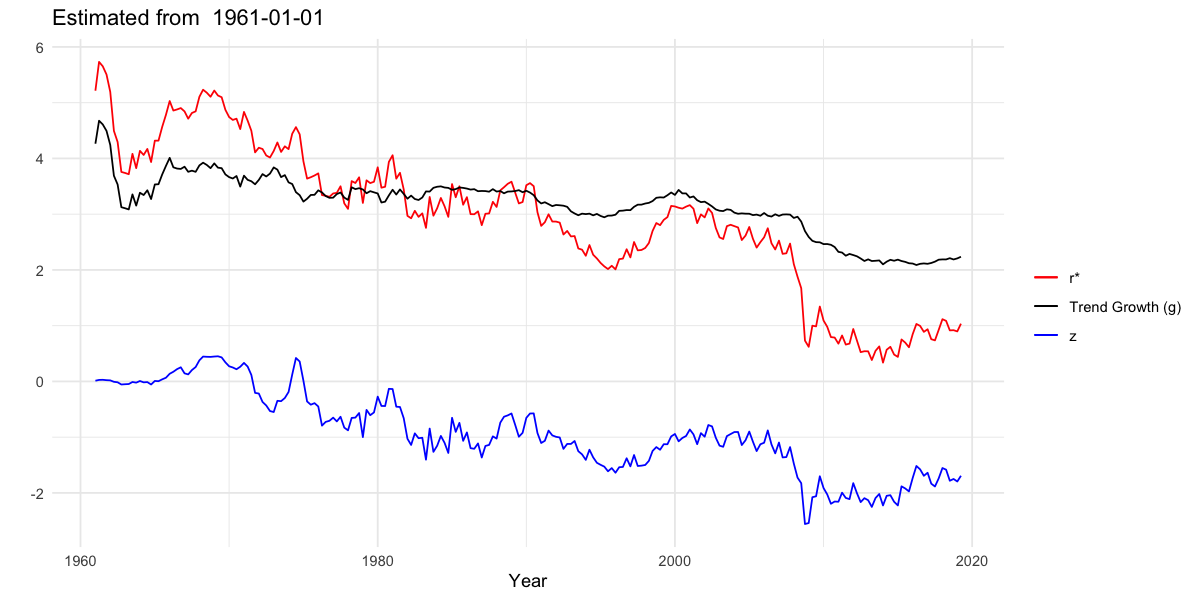

In [ ]:
quarter_dates <- seq(sample.start.date, by = "quarter", length.out = length(out.stage3$rstar.filtered))

df <- data.frame(Year = quarter_dates,
               r_star = out.stage3$rstar.filtered,
               Trend_Growth_g = out.stage3$trend.filtered,
               shock = out.stage3$z.filtered)

options(repr.plot.width=10, repr.plot.height=5)

library(ggplot2)
ggplot(data = df, aes(x = Year)) +
     geom_line(aes(y = r_star, color = "r*")) +
     geom_line(aes(y = Trend_Growth_g, color = "Trend Growth (g)")) +
     geom_line(aes(y = shock, color = "z")) +
     labs(title = paste(inf, " & ", int, " estimated from ", sample.start.date),
          y = "", x = "Year") +
     scale_color_manual(values = c("r*" = "red", "Trend Growth (g)" = "black", "z" = "blue"), 
                         name = "", 
                         breaks = c("r*", "Trend Growth (g)", "z")) +
     scale_linetype_manual(values = c("Trend Growth (g)" = "dotted"), 
                         name = "", 
                         breaks = "Trend Growth (g)") +
theme_minimal() 

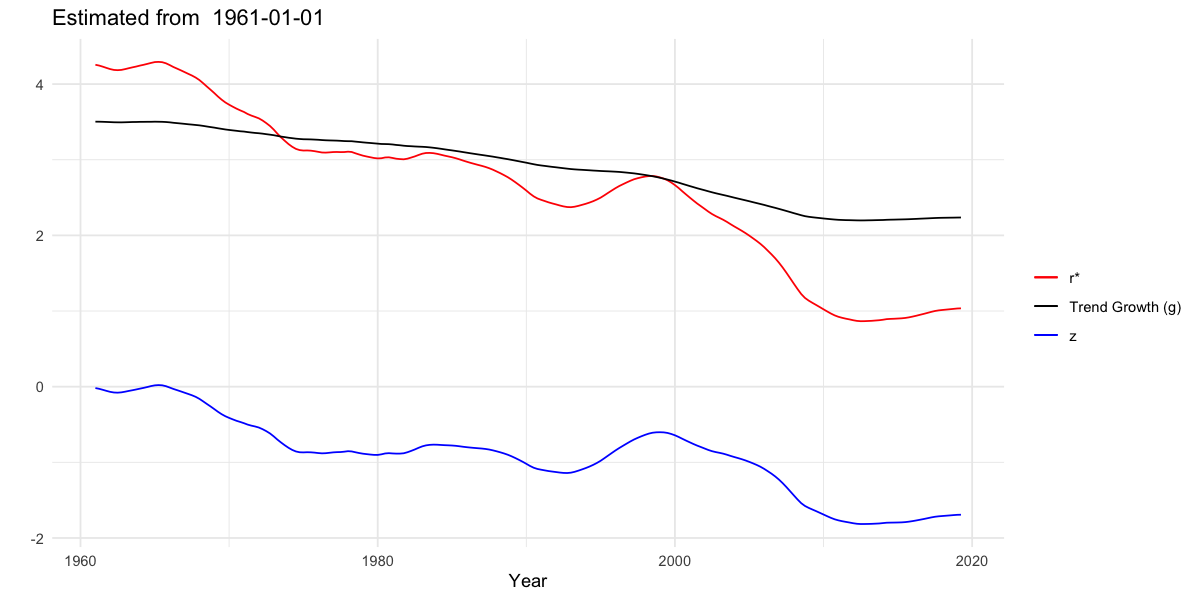

In [ ]:
quarter_dates <- seq(sample.start.date, by = "quarter", length.out = length(out.stage3$rstar.smoothed))

df <- data.frame(Year = quarter_dates,
               r_star = out.stage3$rstar.smoothed,
               Trend_Growth_g = out.stage3$trend.smoothed,
               shock = out.stage3$z.smoothed)

options(repr.plot.width=10, repr.plot.height=5)

library(ggplot2)
ggplot(data = df, aes(x = Year)) +
     geom_line(aes(y = r_star, color = "r*")) +
     geom_line(aes(y = Trend_Growth_g, color = "Trend Growth (g)")) +
     geom_line(aes(y = shock, color = "z")) +
     labs(title = paste(inf, " & ", int, " estimated from ", sample.start.date),
          y = "", x = "Year") +
     scale_color_manual(values = c("r*" = "red", "Trend Growth (g)" = "black", "z" = "blue"), 
                         name = "", 
                         breaks = c("r*", "Trend Growth (g)", "z")) +
     scale_linetype_manual(values = c("Trend Growth (g)" = "dotted"), 
                         name = "", 
                         breaks = "Trend Growth (g)") +
theme_minimal() 